In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import warnings
warnings.simplefilter(action = 'ignore')

In [2]:
amzn = pd.read_csv("dataset/AMZN_2006-01-01_to_2018-01-01.csv")
googl = pd.read_csv("dataset/GOOGL_2006-01-01_to_2018-01-01.csv")
ibm = pd.read_csv("dataset/IBM_2006-01-01_to_2018-01-01.csv")
msft = pd.read_csv("dataset/MSFT_2006-01-01_to_2018-01-01.csv")
aapl = pd.read_csv("dataset/AAPL_2006-01-01_to_2018-01-01.csv")
intc = pd.read_csv("dataset/INTC_2006-01-01_to_2018-01-01.csv")
vz = pd.read_csv("dataset/VZ_2006-01-01_to_2018-01-01.csv")
amd = pd.read_csv("dataset/AMD.csv")
nvda = pd.read_csv("dataset/nvidia_all_time_daily_stock_prices.csv")
aaba = pd.read_csv("dataset/AABA_2006-01-01_to_2018-01-01.csv")

In [3]:
amd['Date'] = pd.to_datetime(amd['Date'])
nvda['Date'] = pd.to_datetime(nvda['Date'])
start_date = pd.to_datetime('2006-01-03')
end_date = pd.to_datetime('2017-12-29')
amd_crop = amd[(amd['Date'] >= start_date) & (amd['Date'] <= end_date)]
amd_crop = amd_crop.reset_index(drop=True)
amd_crop['Close'] = amd_crop['Close'].round(2)
nvda_crop = nvda[(nvda['Date'] >= start_date) & (nvda['Date'] <= end_date)]
nvda_crop = nvda_crop.reset_index(drop = True)
nvda_crop['Close'] = nvda_crop['Close'].round(2)

In [7]:
data = pd.concat([amzn[['Date','Close']], googl["Close"], msft["Close"], aapl["Close"], intc['Close'], 
                  nvda_crop['Close'], ibm["Close"], vz['Close'], aaba['Close'], amd_crop['Close']], axis = 1)
data.columns = ['Date', 'amzn', 'googl', 'msft', 'aapl', 'intc','nvda', 'ibm', 'vz', 'aaba', 'amd']
data['Date'] = pd.to_datetime(data['Date'])
data = data.drop(data.index[-1])
data.set_index('Date', inplace=True)
data.index.to_period('D')
print(isinstance(data.index, pd.DatetimeIndex))

True


In [8]:
data.head(5)

,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba,amd
Date,,,,,,,,,,
2006-01-03,47.58,217.83,26.84,10.68,25.57,3.18,82.06,30.38,40.91,32.40
2006-01-04,47.25,222.84,26.97,10.71,25.91,3.27,81.95,31.27,40.97,32.56
2006-01-05,47.65,225.85,26.99,10.63,26.27,3.35,82.50,31.63,41.53,33.68
2006-01-06,47.87,233.06,26.91,10.90,26.31,3.40,84.95,31.35,43.21,33.78
2006-01-09,47.08,233.68,26.86,10.86,26.47,3.50,83.73,31.48,43.42,33.25


In [9]:
NaN_count = data.isnull().sum()
NaN_count

amzn     0
googl    0
msft     0
aapl     0
intc     0
nvda     0
ibm      0
vz       0
aaba     0
amd      0
dtype: int64

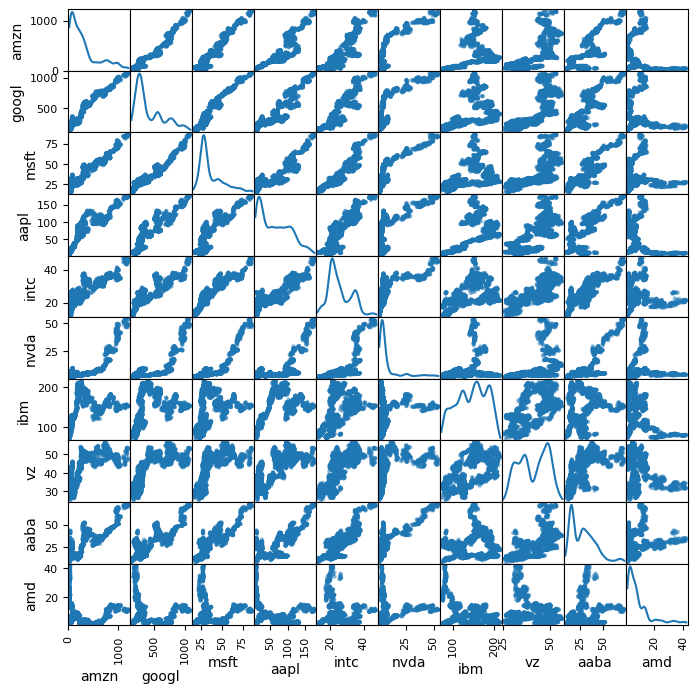

In [10]:
pd.plotting.scatter_matrix(data, figsize = (8,8), diagonal = 'kde')
plt.show()

In [11]:
def adfullertest(data, column_name, difference_order=0):
    if difference_order > 0:
        differenced_data = data[column_name].diff(difference_order).dropna()
        result = adfuller(differenced_data)
        print(f'ADF Statistic for {column_name} (Differencing Order {difference_order}): {result[0]}')
        print(f'p-value for {column_name} (Differencing Order {difference_order}): {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('Is Stationary:', result[1] < 0.05)
    else:
        result = adfuller(data[column_name])
        print(f'ADF Statistic for {column_name}: {result[0]}')
        print(f'p-value for {column_name}: {result[1]}')
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'   {key}: {value}')
        print('Is Stationary:', result[1] < 0.05)

    
#ssuming 'data' is your DataFrame with a datetime index and multiple variables
for column in data.columns:
    adfullertest(data,column)


ADF Statistic for amzn: 2.9638082255195877
p-value for amzn: 1.0
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: False
ADF Statistic for googl: 1.3224241360302167
p-value for googl: 0.9967315857800989
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: False
ADF Statistic for msft: 2.1707913697890535
p-value for msft: 0.9988575993461946
Critical Values:
   1%: -3.4325265517435293
   5%: -2.8625016602846984
   10%: -2.567281916911753
Is Stationary: False
ADF Statistic for aapl: 0.552367204190558
p-value for aapl: 0.9863807814299046
Critical Values:
   1%: -3.4325345499510043
   5%: -2.8625051928165557
   10%: -2.5672837975912697
Is Stationary: False
ADF Statistic for intc: -0.1282667375765534
p-value for intc: 0.9465492557585924
Critical Values:
   1%: -3.4325294533972204
   5%: -2.862502941845959
   10%: -2.567282599200112
Is Stationary: False
ADF Statistic for 

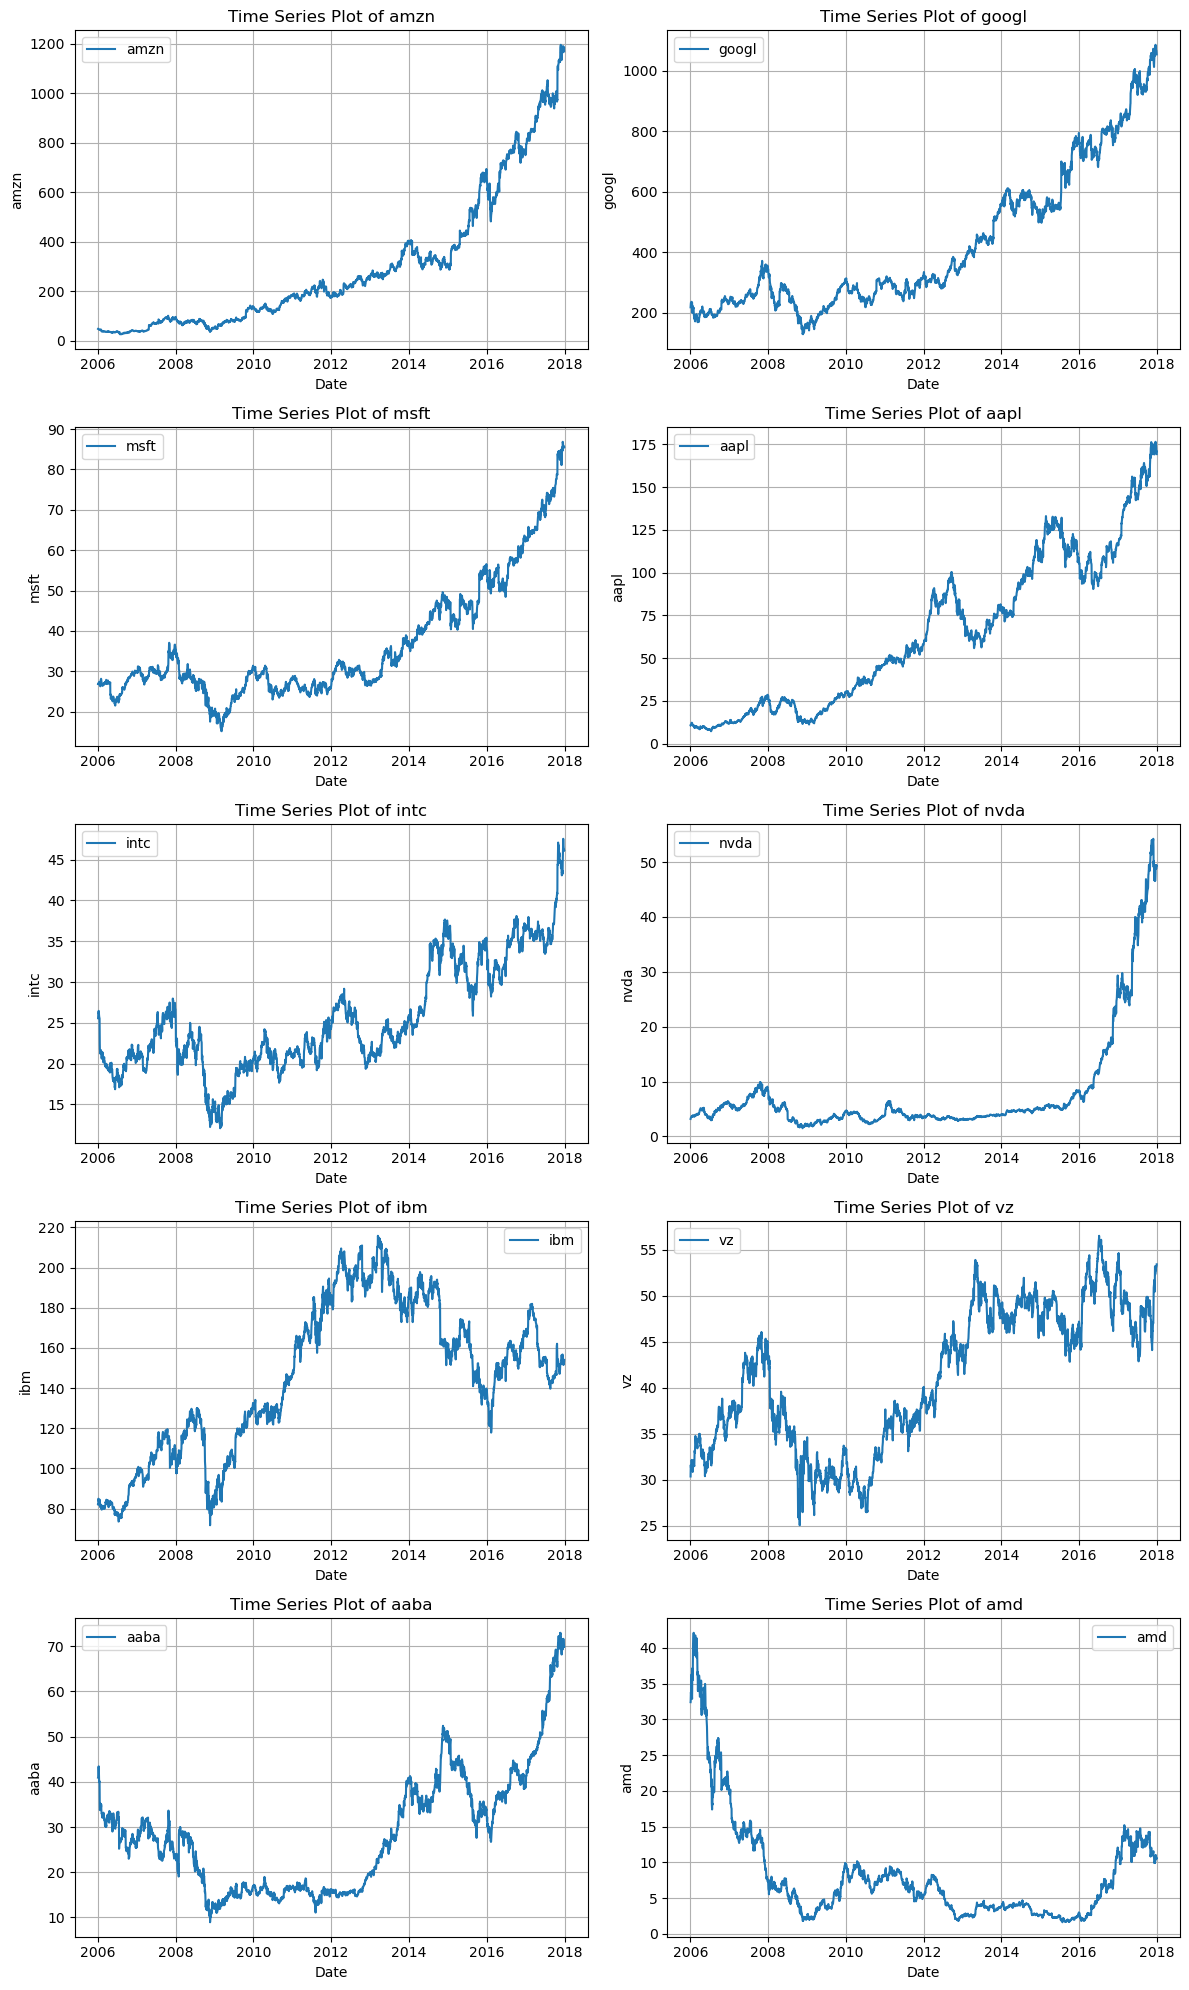

In [12]:
variables_to_plot = data.columns

num_variables = len(variables_to_plot)
num_rows = (num_variables + 1) // 2  
num_cols = 2 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))

# Flatten the axes array if it's not already flat
if num_rows > 1:
    axes = axes.flatten()
else:
    axes = [axes]

for i, variable in enumerate(variables_to_plot):
    row = i // num_cols
    col = i % num_cols

    axes[i].plot(data.index, data[variable], label=variable)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(variable)
    axes[i].set_title('Time Series Plot of ' + variable)
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(num_variables, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [14]:
stationary = data.copy()

In [15]:
adfuller_amzn = adfullertest(stationary, 'amzn', 1)
adfuller_googl = adfullertest(stationary, 'googl', 1)
adfuller_msft = adfullertest(stationary, 'msft', 1)
adfuller_aapl = adfullertest(stationary, 'aapl', 1)
adfuller_intc = adfullertest(stationary, 'intc', 1)
adfuller_nvda = adfullertest(stationary, 'nvda', 1)
adfuller_ibm = adfullertest(stationary, 'ibm', 1)
adfuller_vz = adfullertest(stationary, 'vz', 1)
adfuller_aaba = adfullertest(stationary, 'aaba', 1)
adfuller_amd = adfullertest(stationary, 'amd', 1)


adfuller_amzn
adfuller_googl
adfuller_msft
adfuller_aapl
adfuller_intc
adfuller_nvda
adfuller_ibm
adfuller_vz
adfuller_aaba
adfuller_amd 

ADF Statistic for amzn (Differencing Order 1): -10.094753795777912
p-value for amzn (Differencing Order 1): 1.0983139936571981e-17
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
Is Stationary: True
ADF Statistic for googl (Differencing Order 1): -10.715538736001102
p-value for googl (Differencing Order 1): 3.2487316502660533e-19
Critical Values:
   1%: -3.432540403849221
   5%: -2.862507778275112
   10%: -2.5672851740608125
Is Stationary: True
ADF Statistic for msft (Differencing Order 1): -17.15856610624812
p-value for msft (Differencing Order 1): 6.866235433795143e-30
Critical Values:
   1%: -3.4325265517435293
   5%: -2.8625016602846984
   10%: -2.567281916911753
Is Stationary: True
ADF Statistic for aapl (Differencing Order 1): -11.195686633549675
p-value for aapl (Differencing Order 1): 2.3096464854099648e-20
Critical Values:
   1%: -3.4325345499510043
   5%: -2.8625051928165557
   10%: -2.5672837975912697
Is Stationary: True
ADF 

In [154]:
#ganger1 = grangercausalitytests(stationary[['amzn', 'googl']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0375  , p=0.8465  , df_denom=3015, df_num=1
ssr based chi2 test:   chi2=0.0375  , p=0.8464  , df=1
likelihood ratio test: chi2=0.0375  , p=0.8464  , df=1
parameter F test:         F=0.0375  , p=0.8465  , df_denom=3015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3517  , p=0.7035  , df_denom=3012, df_num=2
ssr based chi2 test:   chi2=0.7045  , p=0.7031  , df=2
likelihood ratio test: chi2=0.7044  , p=0.7031  , df=2
parameter F test:         F=0.3517  , p=0.7035  , df_denom=3012, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3665  , p=0.0690  , df_denom=3009, df_num=3
ssr based chi2 test:   chi2=7.1160  , p=0.0683  , df=3
likelihood ratio test: chi2=7.1076  , p=0.0685  , df=3
parameter F test:         F=2.3665  , p=0.0690  , df_denom=3009, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8345  , p=0.

In [155]:
#ganger1 = grangercausalitytests(stationary[['googl', 'amzn']], 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2630  , p=0.0071  , df_denom=3015, df_num=1
ssr based chi2 test:   chi2=7.2702  , p=0.0070  , df=1
likelihood ratio test: chi2=7.2614  , p=0.0070  , df=1
parameter F test:         F=7.2630  , p=0.0071  , df_denom=3015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9426  , p=0.0195  , df_denom=3012, df_num=2
ssr based chi2 test:   chi2=7.8982  , p=0.0193  , df=2
likelihood ratio test: chi2=7.8879  , p=0.0194  , df=2
parameter F test:         F=3.9426  , p=0.0195  , df_denom=3012, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4205  , p=0.0166  , df_denom=3009, df_num=3
ssr based chi2 test:   chi2=10.2854 , p=0.0163  , df=3
likelihood ratio test: chi2=10.2679 , p=0.0164  , df=3
parameter F test:         F=3.4205  , p=0.0166  , df_denom=3009, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5787  , p=0.

In [156]:
train_df.shape

(2919, 9)

In [102]:
diff_order = 1

In [16]:
train_df = stationary[:-100]
test_df = stationary[-100:]
train_df.shape
model = VAR(train_df)
sorted_order = model.select_order(maxlags = 20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        45.24       45.26   4.460e+19       45.25
1       -3.098      -2.871     0.04515      -3.016
2      -3.327*     -2.894*    0.03592*     -3.171*
3       -3.317      -2.678     0.03627      -3.087
4       -3.305      -2.460     0.03671      -3.000
5       -3.276      -2.225     0.03778      -2.898
6       -3.255      -1.998     0.03859      -2.802
7       -3.227      -1.765     0.03967      -2.700
8       -3.209      -1.540     0.04040      -2.608
9       -3.185      -1.311     0.04138      -2.510
10      -3.155      -1.074     0.04264      -2.405
11      -3.131     -0.8448     0.04367      -2.308
12      -3.118     -0.6252     0.04427      -2.220
13      -3.086     -0.3870     0.04573      -2.113
14      -3.052     -0.1469     0.04732      -2.005
15      -3.028     0.08305     0.04848      -1.907
16      -3.021      0.2954     

In [17]:
var_model = VARMAX(train_df, order = (2,0), enforce_stationarity = True)
fitted_model = var_model.fit(disp = False)
print(fitted_model.summary())

                                                         Statespace Model Results                                                        
Dep. Variable:     ['amzn', 'googl', 'msft', 'aapl', 'intc', 'nvda', 'ibm', 'vz', 'aaba', 'amd']   No. Observations:                 2919
Model:                                                                                    VAR(2)   Log Likelihood             -118759.445
                                                                                     + intercept   AIC                         238048.890
Date:                                                                           Thu, 07 Dec 2023   BIC                         239633.324
Time:                                                                                   19:54:01   HQIC                        238619.601
Sample:                                                                                        0                                         
                                  

In [18]:
n_forecast = 10
predict = fitted_model.get_prediction(start = len(train_df), end = len(train_df) + n_forecast - 1)
predictions = predict.predicted_mean

In [19]:
predictions.columns =  ['amzn_predicted', 'googl_predicted', 'msft_predicted', 'aapl_predicted', 'intc_predicted', 'nvda_predicted', 'ibm_predicted', 'vz_predicted', 'aaba_predicted', 'amd_predicted']
predictions

,amzn_predicted,googl_predicted,msft_predicted,aapl_predicted,intc_predicted,nvda_predicted,ibm_predicted,vz_predicted,aaba_predicted,amd_predicted
2919,1013.176762,980.118960,73.207246,167.352865,39.784544,30.076348,158.634895,51.257557,61.706746,21.009302
2920,1006.575233,976.655653,73.973613,166.690719,40.458735,29.921592,156.207164,51.712202,61.049633,21.671176
2921,1022.465711,994.679148,73.239537,173.027870,41.879634,18.794430,165.965822,50.825719,61.153755,28.572060
2922,1019.411740,996.054523,73.770783,172.544660,42.287960,16.820237,163.585291,50.200190,59.956851,29.318048
2923,1034.182133,1012.265868,73.707174,178.681489,43.559184,7.933870,173.034767,49.365720,60.093495,35.365543
2924,1036.514542,1019.918227,74.626314,178.858556,44.190498,4.987544,172.998847,48.742065,58.958999,36.776129
2925,1046.231323,1030.238885,74.637520,183.589087,45.094194,-2.120454,179.958649,47.706963,58.847782,41.666219
2926,1052.322404,1040.477715,75.429590,184.384264,45.641096,-5.915168,181.407234,46.644664,57.654581,43.636503
2927,1058.429282,1047.834839,75.582999,187.801980,46.323593,-11.607799,186.364106,45.661995,57.424336,47.370745
2928,1067.090783,1059.512318,76.301038,189.124609,46.855370,-15.781794,189.270488,44.487075,56.341337,49.733022


In [20]:
test_df.head(10)

,amzn,googl,msft,aapl,intc,nvda,ibm,vz,aaba,amd
Date,,,,,,,,,,
2017-08-09,982.01,940.08,72.47,161.06,36.59,42.58,142.11,48.60,59.77,13.11
2017-08-10,956.92,923.59,71.41,155.32,36.14,43.03,141.77,48.22,58.03,12.83
2017-08-11,967.99,930.09,72.50,157.48,35.87,41.19,141.84,48.02,57.92,12.12
2017-08-14,983.30,938.93,73.59,159.85,36.34,38.99,141.84,48.06,58.87,12.23
2017-08-15,982.74,938.08,73.22,161.60,36.00,42.10,142.32,48.78,59.99,12.76
2017-08-16,978.18,944.27,73.65,160.95,35.81,41.74,142.07,48.48,60.65,13.02
2017-08-17,960.57,927.66,72.40,157.86,35.17,41.29,142.50,48.41,62.20,12.63
2017-08-18,958.47,926.18,72.49,157.50,35.01,40.37,140.70,47.89,63.07,12.34
2017-08-21,953.29,920.87,72.15,157.21,34.92,40.38,139.70,47.69,63.60,12.37


<Axes: >

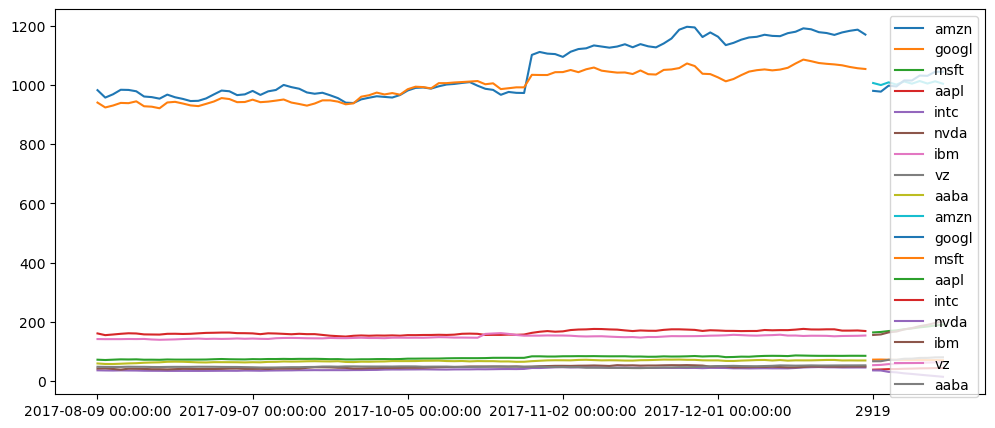

In [130]:
#test_vs_pred = pd.concat([test_df, predictions], axis = 1)
#test_vs_pred.plot(figsize=(12,5))

In [31]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

stocks = ['amzn', 'googl', 'msft', 'aapl', 'intc', 'nvda', 'ibm', 'vz', 'aaba', 'amd']
pmse_values = []
mean_values = []
std_values = []

for stock in stocks:
    # Calculate mean
    mean_value = test_df[stock].head(10).mean()
    mean_values.append(mean_value)
    
    # Calculate PMSE
    pmse_value = math.sqrt(mean_squared_error(predictions[f'{stock}_predicted'], test_df.iloc[1:11][stock]))
    pmse_values.append(pmse_value)
    
    # Calculate standard deviation
    std_value = test_df[stock].head(10).std()
    std_values.append(std_value)

# Calculate PMSE / Mean
pmse_to_mean = [pmse / mean for pmse, mean in zip(pmse_values, mean_values)]

# Calculate PMSE / Std
pmse_to_std = [pmse / std for pmse, std in zip(pmse_values, std_values)]

# Create DataFrame
error = {
    'Stock': stocks,
    'Mean': [round(mean, 2) for mean in mean_values],
    'PMSE': [round(pmse, 2) for pmse in pmse_values],
    'PMSE / Mean': [round(pmse_mean, 2) for pmse_mean in pmse_to_mean],
    'Std': [round(std, 2) for std in std_values],
    'PMSE / Std': [round(pmse_std, 2) for pmse_std in pmse_to_std]
}

Error = pd.DataFrame(error)
Error.head(10)

,Stock,Mean,PMSE,PMSE / Mean,Std,PMSE / Std
0,amzn,969.04,73.64,0.08,11.68,6.31
1,googl,933.02,86.79,0.09,8.25,10.52
2,msft,72.70,2.12,0.03,0.70,3.04
3,aapl,158.86,20.81,0.13,2.07,10.06
4,intc,35.65,8.65,0.24,0.66,13.02
5,nvda,41.15,36.85,0.90,1.27,28.96
6,ibm,141.52,33.38,0.24,0.94,35.59
7,vz,48.23,2.36,0.05,0.34,7.00
8,aaba,60.95,4.96,0.08,2.53,1.96
9,amd,12.55,25.06,2.00,0.38,66.52


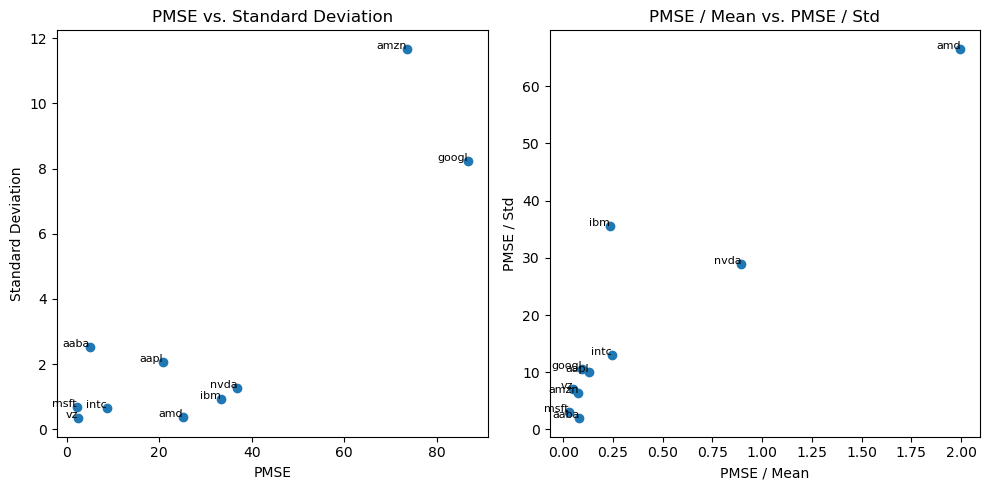

In [34]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pmse_values, std_values)
plt.title('PMSE vs. Standard Deviation')
plt.xlabel('PMSE')
plt.ylabel('Standard Deviation')
for i, stock in enumerate(stocks):
    plt.text(pmse_values[i], std_values[i], stock, fontsize=8, ha='right')

# Plotting PMSE / Std vs. PMSE / Mean
plt.subplot(1, 2, 2)
plt.scatter(pmse_to_mean, pmse_to_std)
plt.title('PMSE / Mean vs. PMSE / Std')
plt.xlabel('PMSE / Mean')
plt.ylabel('PMSE / Std')
for i, stock in enumerate(stocks):
    plt.text(rmse_to_mean[i], rmse_to_std[i], stock, fontsize=8, ha='right')

plt.tight_layout()
plt.show()

In [184]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

mean_amzn_10 = test_df['amzn'].head(10).mean()
rmse_amzn = math.sqrt(mean_squared_error(predictions['amzn_predicted'], test_df.iloc[1:11]['amzn']))
print('AMZN: mean is', mean_amzn_10, 'rmse is', rmse_amzn)
mean_googl_10 = test_df['googl'].head(10).mean()
rmse_googl = math.sqrt(mean_squared_error(predictions['googl_predicted'], test_df.iloc[1:11]['googl']))
print('GOOGL: mean is', mean_googl_10, 'rmse is', rmse_googl)
mean_msft_10 = test_df['msft'].head(10).mean()
rmse_msft = math.sqrt(mean_squared_error(predictions['msft_predicted'], test_df.iloc[1:11]['msft']))
print('MSFT: mean is', mean_msft_10, 'rmse is', rmse_msft)
mean_aapl_10 = test_df['aapl'].head(10).mean()
rmse_aapl = math.sqrt(mean_squared_error(predictions['aapl_predicted'], test_df.iloc[1:11]['aapl']))
print('AAPL: mean is', mean_aapl_10, 'rmse is', rmse_aapl)
mean_intc_10 = test_df['intc'].head(10).mean()
rmse_intc = math.sqrt(mean_squared_error(predictions['intc_predicted'], test_df.iloc[1:11]['intc']))
print('INTC: mean is', mean_intc_10, 'rmse is', rmse_intc)
mean_nvda_10 = test_df['nvda'].head(10).mean()
rmse_nvda = math.sqrt(mean_squared_error(predictions['nvda_predicted'], test_df.iloc[1:11]['nvda']))
print('NVDA: mean is', mean_nvda_10, 'rmse is', rmse_nvda)
mean_ibm_10 = test_df['ibm'].head(10).mean()
rmse_ibm = math.sqrt(mean_squared_error(predictions['ibm_predicted'], test_df.iloc[1:11]['ibm']))
print('IBM: mean is', mean_ibm_10, 'rmse is', rmse_ibm)
mean_vz_10 = test_df['vz'].head(10).mean()
rmse_vz = math.sqrt(mean_squared_error(predictions['vz_predicted'], test_df.iloc[1:11]['vz']))
print('VZ: mean is', mean_vz_10, 'rmse is', rmse_vz)
mean_aaba_10 = test_df['aaba'].head(10).mean()
rmse_aaba = math.sqrt(mean_squared_error(predictions['aaba_predicted'], test_df.iloc[1:11]['aaba']))
print('AABA: mean is', mean_aaba_10, 'rmse is', rmse_aaba)

AMZN: mean is 969.037 rmse is 41.19325523042357
GOOGL: mean is 933.015 rmse is 82.76986064076586
MSFT: mean is 72.704 rmse is 1.3907151110262528
AAPL: mean is 158.861 rmse is 20.01084726079801
INTC: mean is 35.65 rmse is 6.942765849537815
NVDA: mean is 41.146 rmse is 16.599988886812707
IBM: mean is 141.51799999999997 rmse is 39.113744654027634
VZ: mean is 48.229 rmse is 12.002550338365518
AABA: mean is 60.952 rmse is 13.433237840236181


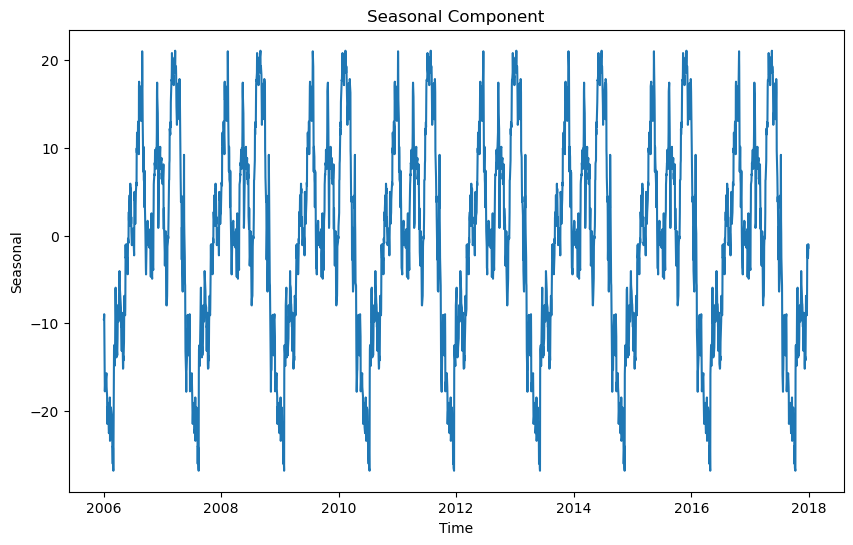

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(stationary['amzn'], model='additive', period = 365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.figure(figsize=(10, 6))
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Seasonal')
plt.show()